In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import glob

from scripts.my_camera_cal import readValuesToUndistort
from scripts.my_camera_cal import unwarp

from scripts.my_pipeline import pipeline
from scripts.my_camera_cal import image_perspective

In [2]:
mtx,dist=readValuesToUndistort("config/myvalues_to_undistort.p")

In [3]:
# Make a list of calibration images
images = glob.glob('../test_images/*.jpg')
print(images)

['../test_images\\straight_lines1.jpg', '../test_images\\straight_lines2.jpg', '../test_images\\test1.jpg', '../test_images\\test2.jpg', '../test_images\\test3.jpg', '../test_images\\test4.jpg', '../test_images\\test5.jpg', '../test_images\\test6.jpg']


In [4]:
# Read in an image
image = mpimg.imread('../test_images/test4.jpg')
print(image.shape)

#undistort it
dst = cv2.undistort(image, mtx, dist, None, mtx)
print(dst.shape)

(720, 1280, 3)
(720, 1280, 3)


In [ ]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [5]:
color_binary,combined_binary= pipeline(dst,channel='s',color_thresh=(110,255), orient='x', sobel_thresh=(20, 100))
print(combined_binary.shape)

(720, 1280)


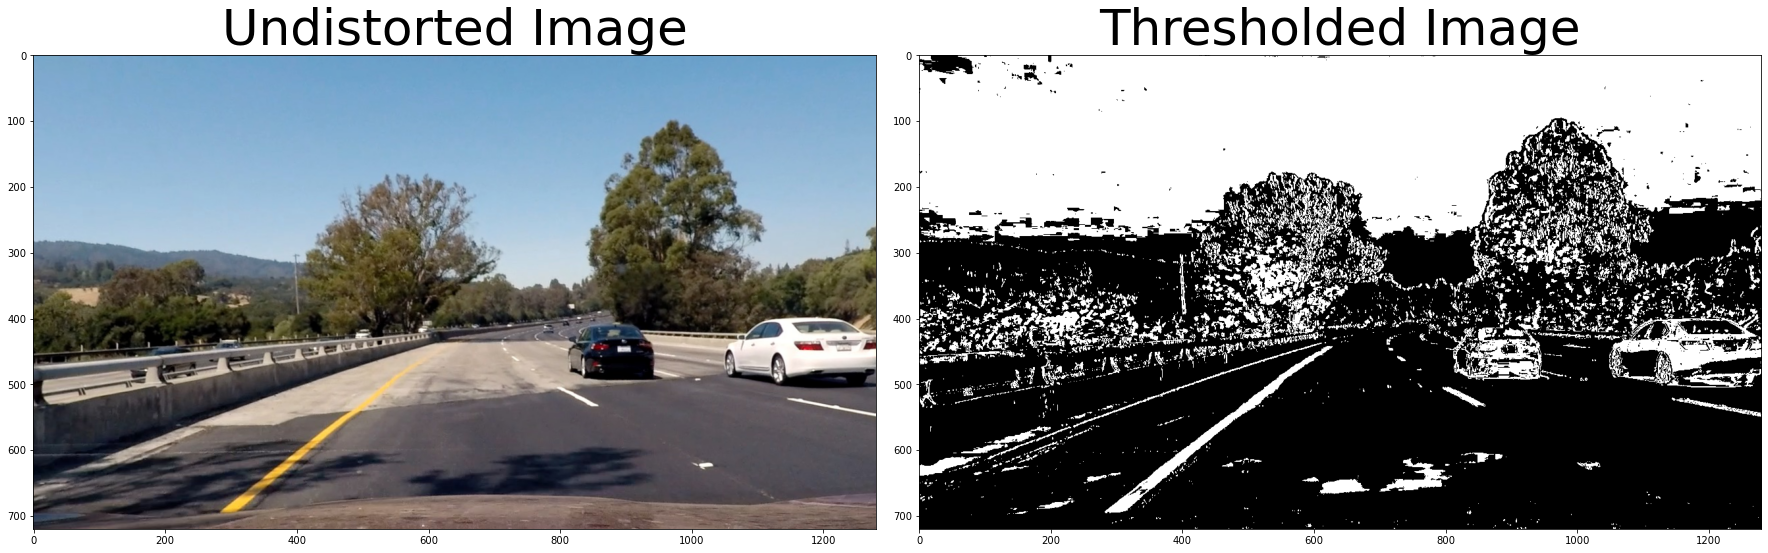

In [6]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(combined_binary,cmap="gray")
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## From here we do a Perspective Transform

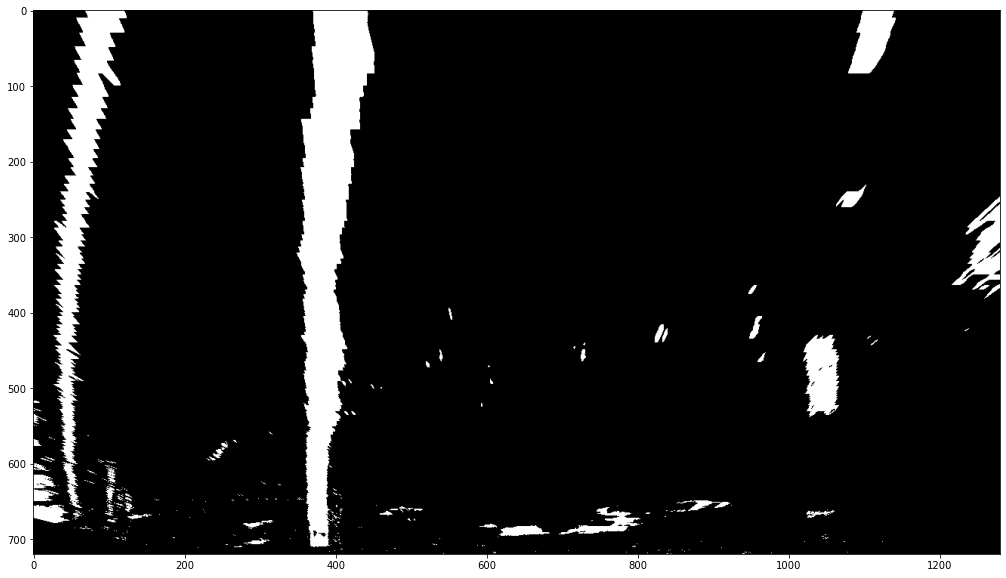

In [7]:
bird_image,M=image_perspective(combined_binary)
plt.figure(figsize=(20,10))
plt.imshow(bird_image,cmap="gray")

# The Histogram

In [9]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]
    plt.imshow(bottom_half,cmap="gray")

    # Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

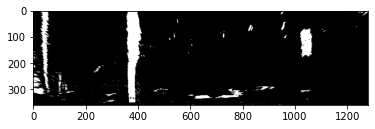

In [10]:
#Normalize the image to 0-1
normalized_image=bird_image
histogram=hist(normalized_image)


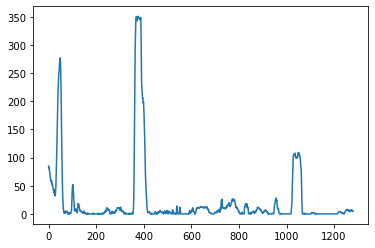

In [11]:
# Visualize the resulting histogram
plt.plot(histogram)

# Note:

>We have to be careful, in the case of test5.jpg we can see a shade in the far part but when we get near this shade could 
desestabiize this histogram taking for a while. 

### Now practice

In [12]:
# Create an output image to draw on and visualize the result
out_img = np.dstack((bird_image, bird_image, bird_image))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

376
1049
640


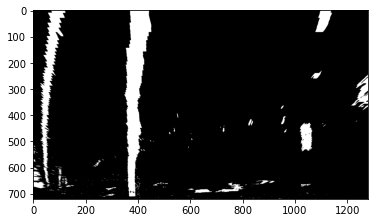

In [13]:
plt.imshow(out_img)
print(leftx_base)
print(rightx_base)
print(midpoint)

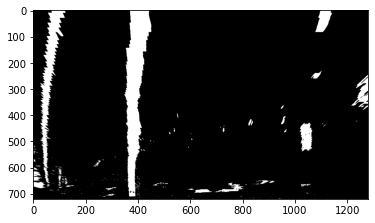

In [14]:
plt.imshow(bird_image,cmap="gray")

In [15]:
# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

In [16]:
# Set height of windows - based on nwindows above and image shape
window_height = np.int(bird_image.shape[0]//nwindows)
# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
nonzero = bird_image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

In [17]:
#These are the coordinates (x,y) of the activated pixels
print(nonzerox)
print(nonzeroy)
print(len(nonzerox))

[ 68  69  70 ... 939 940 941]
[  0   0   0 ... 719 719 719]
72126


In [18]:
print(bird_image.shape)
print("window height is: ",window_height)

(720, 1280)
window height is:  80


In [19]:
# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base
print(leftx_current, rightx_current)

376 1049


In [20]:
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

Now we have to start the iteration

In [21]:
window=0

In [22]:
# Identify window boundaries in x and y (and right and left)
win_y_low = bird_image.shape[0] - (window+1)*window_height
win_y_high = bird_image.shape[0] - window*window_height
print("Low: ",win_y_low)
print("High: ",win_y_high)

Low:  640
High:  720


In [23]:
win_xleft_low = leftx_current - margin
win_xleft_high = leftx_current + margin
win_xright_low = rightx_current - margin
win_xright_high = rightx_current + margin
print(win_xleft_low, win_xleft_high)
print(win_xright_low, win_xright_high)

276 476
949 1149


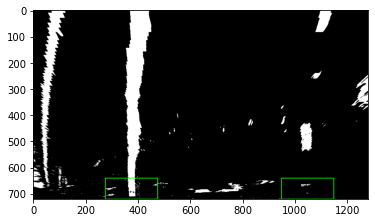

In [24]:
# Draw the windows on the visualization image
cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
plt.imshow(out_img)

In [25]:
# Identify the nonzero pixels in x and y within the window #
good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
print(good_left_inds)
print(good_right_inds)

[65637 65638 65639 ... 72097 72098 72102]
[67553 67674 67675 67788 67789 67790 67791 67792 67793 67794 67795 67796
 67797 67798 67799 67800 67913 67914 67915 67916 67917 67918 67919 67920
 67921 67922 67923 67924 67925 67926 67927 67928 67929 67930 67931 67932
 67933 67934 67935 67936 67937 68070 68071 68072 68073 68074 68075 68076
 68077 68078 68079 68080 68081 68082 68083 68084 68085 68086 68087 68088
 68089 68090 68091 68092 68093 68094 68095 68096 68097 68098 68099 68249
 68250 68251 68252 68253 68254 68255 68256 68257 68258 68259 68260 68261
 68262 68263 68264 68265 68266 68267 68268 68269 68270 68271 68272 68273
 68274 68275 68276 68423 68424 68425 68426 68427 68428 68429 68430 68431
 68432 68433 68434 68435 68436 68437 68438 68439 68440 68441 68442 68570
 68571 68572 68573 68574 68575 68576 68577 68681 68682 68683 68684 68685
 68686 68687 68688 68788 68789 68790 68791 68792 68793 68794 68795 68796
 68897 68898 68899 68900 68901 71508 71509 71570 71571 71572 71635 71636
 71637 71

In [26]:
print(len(good_left_inds))
print(len(good_right_inds))

2184
168


In [ ]:
print(((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)))
print(len(((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high))))


In [ ]:
((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()

In [27]:
# Append these indices to the lists
left_lane_inds.append(good_left_inds)
right_lane_inds.append(good_right_inds)
print(left_lane_inds)

[array([65637, 65638, 65639, ..., 72097, 72098, 72102], dtype=int64)]


In [ ]:
#Here some threshold


if len(good_left_inds) > minpix:
    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
else:
    print("not found")


In [ ]:
# If you found > minpix pixels, recenter next window on their mean position
print(len(good_left_inds))
print(minpix)
print(nonzerox[good_left_inds])
print(np.mean(nonzerox[good_left_inds]))
print("old: ",leftx_current)
if len(good_left_inds) > minpix:
    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
else:
    print("not found")
print(leftx_current)

### WARNING

In the case of test_image4 there is a deviation because in the 4th iteration it finds a very small number of pixels
I think that we should **IGNORE** this if there is a small number of pixels under a threshold and consider them as empty

In [ ]:
print(len(good_right_inds))
print(minpix)
print(nonzerox[good_right_inds])
print(np.mean(nonzerox[good_right_inds]))
print("old: ",rightx_current)

In [ ]:
print("old: ",rightx_current)
if len(good_right_inds) > minpix:        
    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
else:
    print("not found")

print(rightx_current)

In [ ]:
print(left_lane_inds)
print(len(left_lane_inds))
print(left_lane_inds[0])
print(left_lane_inds[1])
print(left_lane_inds[2])

In [ ]:
# Concatenate the arrays of indices (previously was a list of lists of pixels)
try:
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
except ValueError:
    # Avoids an error if the above is not implemented fully
    pass

print(left_lane_inds)
print(len(left_lane_inds))

In [ ]:
# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

In [ ]:
plt.scatter(leftx,lefty,color='red')
plt.scatter(rightx,righty,color='blue')
plt.imshow(out_img)

### Now we have to fit the polinomial

Take into account that we have been doing all this manually. Not automatically with for loops

In [ ]:
# Fit a second order polynomial to each using `np.polyfit`
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

In [ ]:
# Generate x and y values for plotting
ploty = np.linspace(0, bird_image.shape[0]-1, bird_image.shape[0] )

In [ ]:
try:
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
except TypeError:
    # Avoids an error if `left` and `right_fit` are still none or incorrect
    print('The function failed to fit a line!')
    left_fitx = 1*ploty**2 + 1*ploty
    right_fitx = 1*ploty**2 + 1*ploty

In [ ]:
## Visualization ##
# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

In [ ]:
# Plots the left and right polynomials on the lane lines
plt.figure(figsize=(20,10))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img)

In [ ]:
puntos= [(580, 460), (202, 720), (1110, 720), (703, 460)]
puntos.append(puntos[0])
xs, ys = zip(*puntos) #create lists of x and y values
coord2=  [(336, 0), (336, 720), (976, 720), (976, 0)]
coord2.append(coord2[0])
x3s,y3s= zip(*coord2)

In [ ]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.plot(xs,ys,color='green',linewidth=2)
ax1.imshow(combined_binary,cmap='gray')
ax1.set_title('World Image', fontsize=50)
ax2.plot(x3s,y3s,color='green',linewidth=2)
ax2.imshow(bird_image,cmap="gray")
ax2.set_title('Bird View', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(xs,ys,color='green',linewidth=2)
plt.imshow(combined_binary,cmap="gray")

Just for laughs :)

In [ ]:
bird_image2,M2=image_perspective(dst)
plt.figure(figsize=(20,10))
plt.plot(x3s,y3s,color='green',linewidth=2)
plt.imshow(bird_image2)